# Kaggel

## Api upload

In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lebwie","key":"95150c00c88b952026131334fc329671"}'}

## Setup Kaggle CLI in Colab and Download Dataset

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d gti-upm/leapgestrecog

# Unzip
!unzip leapgestrecog.zip -d leapGestRecog


Streaming output truncated to the last 5000 lines.
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapGestRecog/leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapGestRecog/leapgestrecog/leapGest

# Preprocessing Data

In [12]:
import os

base_path = "leapGestRecog"

for subject in sorted(os.listdir(base_path)):
    subject_path = os.path.join(base_path, subject)
    if os.path.isdir(subject_path):
        print(f"📁 Subject: {subject}")
        for gesture in sorted(os.listdir(subject_path)):
            gesture_path = os.path.join(subject_path, gesture)
            if os.path.isdir(gesture_path):
                print(f"  ↳ Gesture: {gesture}")


📁 Subject: leapGestRecog
  ↳ Gesture: 00
  ↳ Gesture: 01
  ↳ Gesture: 02
  ↳ Gesture: 03
  ↳ Gesture: 04
  ↳ Gesture: 05
  ↳ Gesture: 06
  ↳ Gesture: 07
  ↳ Gesture: 08
  ↳ Gesture: 09
📁 Subject: leapgestrecog
  ↳ Gesture: leapGestRecog


In [13]:
import os
import cv2
import numpy as np
from tqdm import tqdm

data_dir = 'leapGestRecog/leapGestRecog'
image_size = 64

X = []
y = []
labels_dict = {}
label_count = 0

# Iterate over each subject folder (00 to 09)
for subject in sorted(os.listdir(data_dir)):
    subject_path = os.path.join(data_dir, subject)
    if not os.path.isdir(subject_path):
        continue

    # Iterate over gesture folders inside each subject
    for gesture in sorted(os.listdir(subject_path)):
        gesture_path = os.path.join(subject_path, gesture)
        if not os.path.isdir(gesture_path):
            continue

        # Assign label ID
        if gesture not in labels_dict:
            labels_dict[gesture] = label_count
            label_count += 1
        label = labels_dict[gesture]

        # Read all images inside gesture folder
        for img_file in tqdm(os.listdir(gesture_path), desc=f"{gesture}"):
            img_path = os.path.join(gesture_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            y.append(label)

X = np.array(X).reshape(-1, image_size, image_size, 1) / 255.0
y = np.array(y)

print("✅ Loaded", X.shape[0], "images")
print("📦 Shape:", X.shape)
print("🔖 Labels:", y.shape)
print("📚 Label mapping:", labels_dict)


10_down: 100%|██████████| 200/200 [00:00<00:00, 561.95it/s]


✅ Loaded 20000 images
📦 Shape: (20000, 64, 64, 1)
🔖 Labels: (20000,)
📚 Label mapping: {'01_palm': 0, '02_l': 1, '03_fist': 2, '04_fist_moved': 3, '05_thumb': 4, '06_index': 5, '07_ok': 6, '08_palm_moved': 7, '09_c': 8, '10_down': 9}


# Model Building

## CNN

In [15]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

# Build CNN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 69s 165ms/step - accuracy: 0.7109 - loss: 0.8585 - val_accuracy: 0.9978 - val_loss: 0.0122
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 64s 160ms/step - accuracy: 0.9913 - loss: 0.0302 - val_accuracy: 0.9984 - val_loss: 0.0077
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 65s 162ms/step - accuracy: 0.9953 - loss: 0.0146 - val_accuracy: 0.9981 - val_loss: 0.0074
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 85s 169ms/step - accuracy: 0.9944 - loss: 0.0161 - val_accuracy: 0.9962 - val_loss: 0.0132
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 70s 174ms/step - accuracy: 0.9980 - loss: 0.0070 - val_accuracy: 0.9972 - val_loss: 0.0115
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 80s 168ms/step - accuracy: 0.9948 - loss: 0.0141 - val_accuracy: 0.9991 - val_loss: 0.0051
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 81s 167ms/step - accuracy: 0.9977 - loss: 0.0077 - val_accuracy: 0.9994 - val_loss: 0.0031
Epoch 8/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 67s 166ms/step - accuracy: 0.9988 - loss: 0

# Model Evaluation

In [18]:
# Evaluate and show results
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"❌ Test Loss: {test_loss:.4f}")


✅ Test Accuracy: 0.9998
❌ Test Loss: 0.0007


## Accuracy and Lost Curves

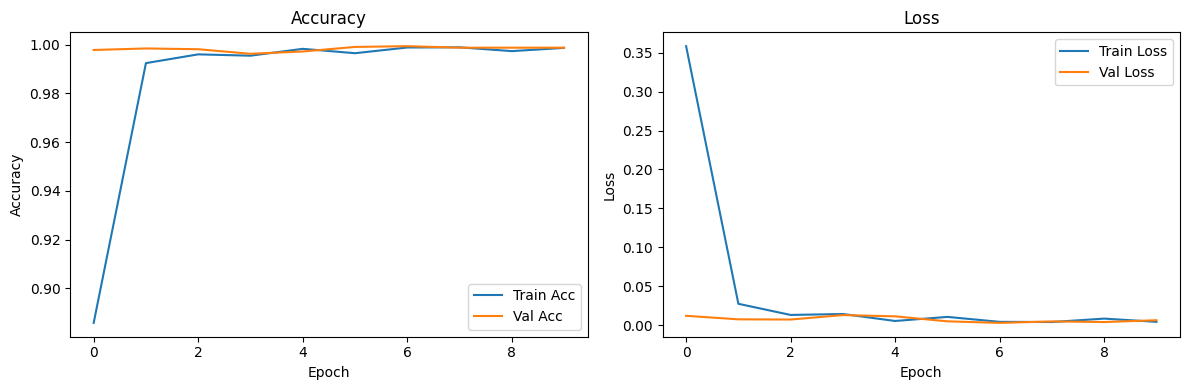

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


# Test Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


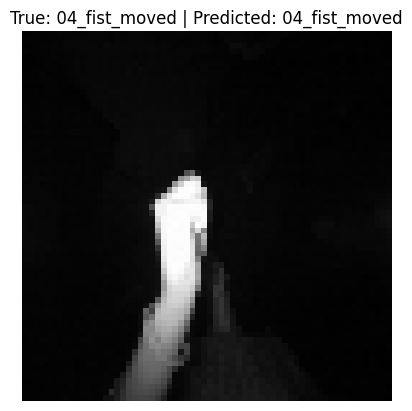

In [21]:
import random

idx = random.randint(0, X_test.shape[0] - 1)
sample = X_test[idx]
label = np.argmax(y_test[idx])

prediction = model.predict(sample.reshape(1, 64, 64, 1))
predicted_label = np.argmax(prediction)

# Invert label dictionary
inv_labels_dict = {v: k for k, v in labels_dict.items()}

plt.imshow(sample.reshape(64, 64), cmap='gray')
plt.title(f"True: {inv_labels_dict[label]} | Predicted: {inv_labels_dict[predicted_label]}")
plt.axis('off')
plt.show()
